In [29]:
# based on https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools # to create the all possible combinations of hyperparameters
from tqdm import tqdm
from tabulate import tabulate
import pandas as pd

In [30]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Hyperparameters
input_size = 784
num_classes = 10
hidden_sizes = [100,500,2000] 
num_epochs = [5] 
batch_sizes = [100,250,500]
learning_rates = [0.0001, 0.001, 0.01]

default_batch_size = 100
validation_size = 10000 # number for validation

number_of_seeds = 1 # number of random seeds to generate

In [32]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
										   train=True,
										   transform=transforms.ToTensor(),
										   download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
										  train=False,
										  transform=transforms.ToTensor())

# Split dataset into training and validation sets
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
										   batch_size=default_batch_size,
										   shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                        batch_size=default_batch_size,
                        shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
										  batch_size=default_batch_size,
										  shuffle=False)

In [33]:
def change_batch_size(loader, new_batch_size):
    loader.batch_sampler.batch_size = new_batch_size

def print_curr_combination(combination):
    seed_number = combination[0]
    hidden_size = combination[1]
    num_of_epochs = combination[2]
    learning_rate = combination[3]
    batch_size = combination[4]

    print(f"Seed number: #{seed_number}, hidden_size: {hidden_size}, # Epochs: {num_of_epochs}, learning_rate: {learning_rate}, batch_size: {batch_size}")

def generate_seed_numbers(number_of_seeds):
    return [random.randint(0, 100) for _ in range(number_of_seeds)]

def generate_combinations():
    seed_numbers = generate_seed_numbers(number_of_seeds)

    num_of_iterations = len(seed_numbers) * len(hidden_sizes) *len(num_epochs) *len(learning_rates) *len(batch_sizes)
    # Generate all possible combinations
    combinations      =  itertools.product(seed_numbers,hidden_sizes, num_epochs,learning_rates,batch_sizes)

    return combinations, num_of_iterations
    

In [34]:
# Fully connected neural network
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		return out

In [35]:
criterion = nn.CrossEntropyLoss() # this is the loss function
combinations, num_of_iterations = generate_combinations()

In [36]:
def evaluate_model(model,data_loader):
    total_loss = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images = images.reshape(-1, 28*28).to(device) # convert to vector
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # takes max of last layer as prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss+=loss.item()
        
        data_errors = total_loss/len(data_loader) # get mean error
        
    return data_errors

In [37]:
def train_model(seed_number,hidden_size,num_epochs,learning_rate,batch_size):
	# set the seed
	torch.manual_seed(seed_number)
	# print("Using seed number: ",seed_number)

	change_batch_size(train_loader,batch_size)
	change_batch_size(test_loader,batch_size)
	change_batch_size(val_loader,batch_size)

	model = NeuralNet(input_size, hidden_size, num_classes).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # this is the algorithm used like gradient descent
		
	# train the model
	all_epochs_test_errors = []
	all_epochs_val_errors = []
	for epoch in range(num_epochs):
		# set model to train mode
		model.train()
		for i, (images, labels) in enumerate(train_loader):
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

		# get e_te of each epoch
		test_errors = evaluate_model(model,test_loader)
		val_errors = evaluate_model(model,val_loader)
		
		print('Epoch [{}/{}], Seed [{}] Test Loss: {:.4f}'.format(epoch+1, num_epochs,seed_number, test_errors))

		all_epochs_test_errors.append(test_errors) # aggregate each epoch's error from this seed
		all_epochs_val_errors.append(val_errors)   # aggregate each epoch's error from this seed

	return model, all_epochs_test_errors,all_epochs_val_errors


In [38]:
# main
training_tests_errors = []
training_val_errors = []
final_tests_errors    = []

for i,combination in tqdm(enumerate(combinations),total=num_of_iterations):
    # print(f'Iteration {i+1}/{num_of_iterations}')
    print_curr_combination(combination)
    curr_model, curr_test_errors,curr_val_errors = train_model(combination[0],combination[1],combination[2],combination[3],combination[4])
    training_tests_errors.append(curr_test_errors)
    training_val_errors.append(curr_val_errors)
    final_tests_errors.append(curr_test_errors[-1]) # get last valid test error from each seed


  0%|          | 0/27 [00:00<?, ?it/s]

Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.0001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.6260
Epoch [2/5], Seed [29] Test Loss: 0.4101
Epoch [3/5], Seed [29] Test Loss: 0.3437
Epoch [4/5], Seed [29] Test Loss: 0.3094


  4%|▎         | 1/27 [00:41<18:03, 41.69s/it]

Epoch [5/5], Seed [29] Test Loss: 0.2893
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.0001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 1.1278
Epoch [2/5], Seed [29] Test Loss: 0.6469
Epoch [3/5], Seed [29] Test Loss: 0.4851
Epoch [4/5], Seed [29] Test Loss: 0.4096


  7%|▋         | 2/27 [01:15<15:26, 37.07s/it]

Epoch [5/5], Seed [29] Test Loss: 0.3676
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.0001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 1.6354
Epoch [2/5], Seed [29] Test Loss: 1.0639
Epoch [3/5], Seed [29] Test Loss: 0.7625
Epoch [4/5], Seed [29] Test Loss: 0.6037


 11%|█         | 3/27 [01:47<13:57, 34.88s/it]

Epoch [5/5], Seed [29] Test Loss: 0.5112
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.2401
Epoch [2/5], Seed [29] Test Loss: 0.1749
Epoch [3/5], Seed [29] Test Loss: 0.1468
Epoch [4/5], Seed [29] Test Loss: 0.1234


 15%|█▍        | 4/27 [02:25<13:50, 36.11s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1117
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.2987
Epoch [2/5], Seed [29] Test Loss: 0.2323
Epoch [3/5], Seed [29] Test Loss: 0.1929
Epoch [4/5], Seed [29] Test Loss: 0.1670


 19%|█▊        | 5/27 [02:59<12:54, 35.20s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1496
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.3596
Epoch [2/5], Seed [29] Test Loss: 0.2778
Epoch [3/5], Seed [29] Test Loss: 0.2413
Epoch [4/5], Seed [29] Test Loss: 0.2146


 22%|██▏       | 6/27 [03:31<11:54, 34.04s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1933
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.01, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.1435
Epoch [2/5], Seed [29] Test Loss: 0.1380
Epoch [3/5], Seed [29] Test Loss: 0.1427
Epoch [4/5], Seed [29] Test Loss: 0.1502


 26%|██▌       | 7/27 [04:08<11:42, 35.15s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1391
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.01, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.1578
Epoch [2/5], Seed [29] Test Loss: 0.1092
Epoch [3/5], Seed [29] Test Loss: 0.1089
Epoch [4/5], Seed [29] Test Loss: 0.1040


 30%|██▉       | 8/27 [04:41<10:56, 34.55s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1198
Seed number: #29, hidden_size: 100, # Epochs: 5, learning_rate: 0.01, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.1751
Epoch [2/5], Seed [29] Test Loss: 0.1347
Epoch [3/5], Seed [29] Test Loss: 0.1047
Epoch [4/5], Seed [29] Test Loss: 0.0978


 33%|███▎      | 9/27 [05:14<10:11, 33.96s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1014
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.0001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.3863
Epoch [2/5], Seed [29] Test Loss: 0.2955
Epoch [3/5], Seed [29] Test Loss: 0.2558
Epoch [4/5], Seed [29] Test Loss: 0.2292


 37%|███▋      | 10/27 [05:51<09:55, 35.00s/it]

Epoch [5/5], Seed [29] Test Loss: 0.2064
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.0001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.5908
Epoch [2/5], Seed [29] Test Loss: 0.3830
Epoch [3/5], Seed [29] Test Loss: 0.3189
Epoch [4/5], Seed [29] Test Loss: 0.2881


 41%|████      | 11/27 [06:23<09:04, 34.01s/it]

Epoch [5/5], Seed [29] Test Loss: 0.2650
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.0001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.9901
Epoch [2/5], Seed [29] Test Loss: 0.5479
Epoch [3/5], Seed [29] Test Loss: 0.4170
Epoch [4/5], Seed [29] Test Loss: 0.3589


 44%|████▍     | 12/27 [06:55<08:21, 33.41s/it]

Epoch [5/5], Seed [29] Test Loss: 0.3255
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.1598
Epoch [2/5], Seed [29] Test Loss: 0.1034
Epoch [3/5], Seed [29] Test Loss: 0.0854
Epoch [4/5], Seed [29] Test Loss: 0.0853


 48%|████▊     | 13/27 [07:31<07:59, 34.25s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0689
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.2214
Epoch [2/5], Seed [29] Test Loss: 0.1466
Epoch [3/5], Seed [29] Test Loss: 0.1194
Epoch [4/5], Seed [29] Test Loss: 0.1074


 52%|█████▏    | 14/27 [08:03<07:15, 33.48s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0874
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.2630
Epoch [2/5], Seed [29] Test Loss: 0.1964
Epoch [3/5], Seed [29] Test Loss: 0.1502
Epoch [4/5], Seed [29] Test Loss: 0.1267


 56%|█████▌    | 15/27 [08:34<06:33, 32.77s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1111
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.01, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.1391
Epoch [2/5], Seed [29] Test Loss: 0.1208
Epoch [3/5], Seed [29] Test Loss: 0.1455
Epoch [4/5], Seed [29] Test Loss: 0.1589


 59%|█████▉    | 16/27 [09:10<06:10, 33.70s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1322
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.01, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.1169
Epoch [2/5], Seed [29] Test Loss: 0.0904
Epoch [3/5], Seed [29] Test Loss: 0.1146
Epoch [4/5], Seed [29] Test Loss: 0.1354


 63%|██████▎   | 17/27 [09:42<05:30, 33.06s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1249
Seed number: #29, hidden_size: 500, # Epochs: 5, learning_rate: 0.01, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.1285
Epoch [2/5], Seed [29] Test Loss: 0.0949
Epoch [3/5], Seed [29] Test Loss: 0.1026
Epoch [4/5], Seed [29] Test Loss: 0.0905


 67%|██████▋   | 18/27 [10:13<04:52, 32.48s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0906
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.0001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.2900
Epoch [2/5], Seed [29] Test Loss: 0.2226
Epoch [3/5], Seed [29] Test Loss: 0.1811
Epoch [4/5], Seed [29] Test Loss: 0.1559


 70%|███████   | 19/27 [10:49<04:28, 33.62s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1362
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.0001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.3832
Epoch [2/5], Seed [29] Test Loss: 0.2833
Epoch [3/5], Seed [29] Test Loss: 0.2434
Epoch [4/5], Seed [29] Test Loss: 0.2107


 74%|███████▍  | 20/27 [11:21<03:52, 33.18s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1897
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.0001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.5534
Epoch [2/5], Seed [29] Test Loss: 0.3567
Epoch [3/5], Seed [29] Test Loss: 0.2966
Epoch [4/5], Seed [29] Test Loss: 0.2617


 78%|███████▊  | 21/27 [11:52<03:15, 32.61s/it]

Epoch [5/5], Seed [29] Test Loss: 0.2381
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.001, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.1124
Epoch [2/5], Seed [29] Test Loss: 0.0767
Epoch [3/5], Seed [29] Test Loss: 0.0689
Epoch [4/5], Seed [29] Test Loss: 0.0769


 81%|████████▏ | 22/27 [12:32<02:53, 34.79s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0704
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.001, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.1489
Epoch [2/5], Seed [29] Test Loss: 0.1010
Epoch [3/5], Seed [29] Test Loss: 0.0800
Epoch [4/5], Seed [29] Test Loss: 0.0760


 85%|████████▌ | 23/27 [13:04<02:15, 33.96s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0738
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.001, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.1978
Epoch [2/5], Seed [29] Test Loss: 0.1330
Epoch [3/5], Seed [29] Test Loss: 0.1079
Epoch [4/5], Seed [29] Test Loss: 0.0884


 89%|████████▉ | 24/27 [13:35<01:39, 33.00s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0757
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.01, batch_size: 100
Epoch [1/5], Seed [29] Test Loss: 0.1543
Epoch [2/5], Seed [29] Test Loss: 0.1252
Epoch [3/5], Seed [29] Test Loss: 0.1466
Epoch [4/5], Seed [29] Test Loss: 0.1585


 93%|█████████▎| 25/27 [14:10<01:07, 33.68s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1944
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.01, batch_size: 250
Epoch [1/5], Seed [29] Test Loss: 0.1058
Epoch [2/5], Seed [29] Test Loss: 0.0990
Epoch [3/5], Seed [29] Test Loss: 0.1079
Epoch [4/5], Seed [29] Test Loss: 0.1181


 96%|█████████▋| 26/27 [14:45<00:34, 34.06s/it]

Epoch [5/5], Seed [29] Test Loss: 0.1308
Seed number: #29, hidden_size: 2000, # Epochs: 5, learning_rate: 0.01, batch_size: 500
Epoch [1/5], Seed [29] Test Loss: 0.1117
Epoch [2/5], Seed [29] Test Loss: 0.0890
Epoch [3/5], Seed [29] Test Loss: 0.0893
Epoch [4/5], Seed [29] Test Loss: 0.0895


100%|██████████| 27/27 [15:17<00:00, 33.99s/it]

Epoch [5/5], Seed [29] Test Loss: 0.0900


In [39]:
# # Graphs for each seed
# seed_id = 0
# for i,curr_training_val_error in enumerate(training_val_errors):
#     x_axis = np.arange(1, len(curr_training_val_error) + 1) # so x axis is from 1 to 5
#     plt.plot(x_axis,curr_training_val_error, label=f'Validate Seed #{seed_numbers[seed_id]}', linestyle=":")
#     seed_id+=1

# seed_id = 0
# for i,curr_training_tests_error in enumerate(training_tests_errors):
#     x_axis = np.arange(1, len(curr_training_tests_error) + 1) # so x axis is from 1 to 5
#     plt.plot(x_axis,curr_training_tests_error, label=f'Test Seed #{seed_numbers[seed_id]}')
#     seed_id+=1

# plt.ylabel("Error")
# plt.xlabel("Epochs")
# plt.title("Task 3: Test and Validate Errors Graph Per Seed")
# # plt.yscale('log')
# # plt.xscale('log')
# plt.legend()
# plt.show()

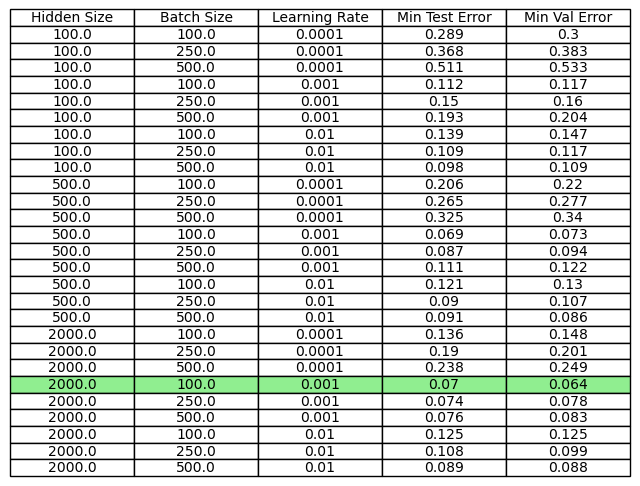

In [40]:
table_data = []
headers = ["Hidden Size", "Batch Size", "Learning Rate", "Min Test Error", "Min Val Error"]

combinations, _ = generate_combinations()
for i,combination in enumerate(combinations):
    min_error_val = min(training_val_errors[i])
    index_of_min = training_val_errors[i].index(min_error_val)
    min_correspond_test = training_tests_errors[i][index_of_min]
    # print('Combination {}: ({:.4f},{:.4f})'.format(combination,min_correspond_test,min_error_val))
    table_data.append([combination[1],combination[4],combination[3],round(min_correspond_test,3),round(min_error_val,3)])

# Print the table
# print(tabulate(table_data, headers=headers, floatfmt=".4f"))

df = pd.DataFrame(table_data, columns=headers)

# Find the row with the minimum validation error
min_val_error_row = df["Min Val Error"].idxmin()

# Plot the table
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Highlight the row with the least validation error
for key, cell in table.get_celld().items():
    if key[0] == min_val_error_row + 1:  # +1 because header row is row 0
        cell.set_facecolor('lightgreen')
        
# Save the table as a PNG image
plt.savefig("table.png", bbox_inches='tight', pad_inches=0.1)
plt.show()
